In [2]:
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
## extract data from xml files into txt files
import xml.etree.ElementTree as ET

img_width = 504
img_height = 747

base_dir = 'data/custom/labels'
len = 0
for xml_file in os.listdir(base_dir):
    if xml_file.endswith('xml'):
        len += 1
# print(len)

for ind in range(len):
    xml_file = f'{ind}.xml'
    root = ET.parse(os.path.join(base_dir, xml_file)).getroot()
    txt_file = f'{ind}.txt'

    f = open(os.path.join(base_dir, txt_file), 'w+')
    for object in root.findall('./object/bndbox'):
        xmin = int(object[0].text)
        ymin = int(object[1].text)
        xmax = int(object[2].text)
        ymax = int(object[3].text)

        xcenter = ((xmin + xmax) / 2.0) / img_width
        ycenter = ((ymin + ymax) / 2.0) / img_height
        bbox_width = (xmax - xmin) / img_width
        bbox_height = (ymax - ymin) / img_height

        # f.write(f'0 {xcenter} {ycenter} {bbox_width} {bbox_height}\n')
        print(f'0 {xcenter} {ycenter} {bbox_width} {bbox_height}')
    f.close()
    print('\n')


0 0.9146825396825397 0.19544846050870146 0.16666666666666666 0.10174029451137885
0 0.4642857142857143 0.29518072289156627 0.32936507936507936 0.09504685408299866
0 0.08531746031746032 0.17737617135207498 0.1626984126984127 0.11646586345381527


0 0.9226190476190477 0.2543507362784471 0.15079365079365079 0.11244979919678715
0 0.5734126984126984 0.37751004016064255 0.21428571428571427 0.10174029451137885
0 0.20734126984126985 0.33065595716198126 0.20833333333333334 0.107095046854083


0 0.9226190476190477 0.25301204819277107 0.15476190476190477 0.12048192771084337
0 0.5793650793650794 0.3788487282463186 0.2222222222222222 0.107095046854083
0 0.20634920634920634 0.3326639892904953 0.19047619047619047 0.09504685408299866


0 0.9206349206349206 0.24765729585006693 0.15873015873015872 0.11244979919678715
0 0.5694444444444444 0.37215528781793844 0.24206349206349206 0.10977242302543508
0 0.22321428571428573 0.33065595716198126 0.21626984126984128 0.10441767068273092


0 0.9226190476190477 0.24

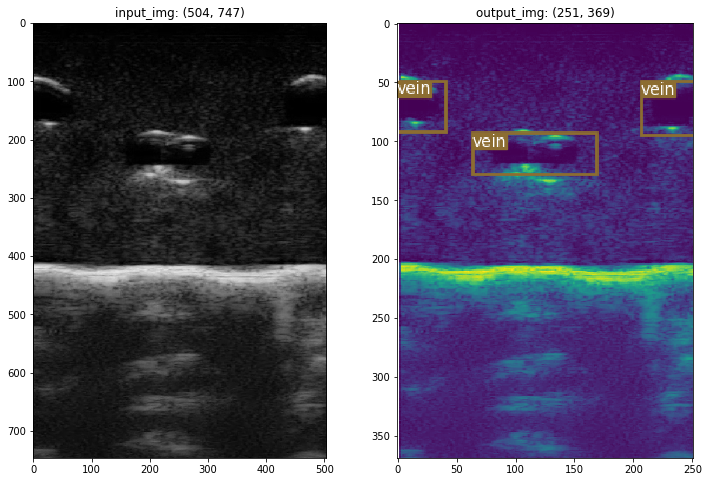

In [9]:
input_img = Image.open('data/custom/images/0.jpg').convert('RGB')
output_img = Image.open('output/0.png')

imgs = [input_img, output_img]
titles = [f'input_img: {input_img.size}', f'output_img: {output_img.size}']
plt.figure(figsize=(12,8))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)